In [1]:
import sys
%matplotlib inline
import numpy as np
import os
import matplotlib.pyplot
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import matplotlib.dates as mdates
import datetime
from tqdm import tqdm
import GPy
from collections import defaultdict
from pathlib import Path
import seaborn as sns
import scipy.stats as stats
from matplotlib.colors import ListedColormap
import warnings
import time
from itertools import product
from joblib import Parallel, delayed
from operator import itemgetter
import sncosmo
import emcee
import corner

mpl.rcParams['legend.frameon'] = False
mpl.rcParams['figure.autolayout'] = True
# mpl.rcParams['figure.dpi'] = 300
# mpl.rcParams['axes.spines.right'] = False
# mpl.rcParams['axes.spines.top'] = False


plt.rcParams.update({
    "text.usetex": True,
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica"]})

plt.rcParams.update({
    "text.usetex": True,
    "font.family": "serif",
    "font.serif": ["Palatino"],
})


def utkarshGrid():
    plt.minorticks_on()
    plt.grid(color='grey',
             which='minor',
             linestyle=":",
             linewidth='0.1',
             )
    plt.grid(color='black',
             which='major',
             linestyle=":",
             linewidth='0.1',
             )
    
# set random number seed to ensure reproducibility
seed = 3
rstate = np.random.RandomState(seed)

In [2]:
truth_arr = np.array([-1, 3, 1, -1])


def model(x, a, b, c, d):
    return a*x**3 + b*x**2 + c*x + d

def gen_mock_data(a=truth_arr[0], b = truth_arr[1], c = truth_arr[2],d = truth_arr[3], N = 100):
    x = np.sort(3. * rstate.rand(N))  # x values
    y = model(x, a, b, c, d)
    yerr = np.random.uniform(0.1, 0.4, N)
    yobs = np.random.normal(y, yerr)
    return x, yobs

In [3]:
a_guess, b_guess, c_guess, d_guess = [0, 0, 0, 0]

(100,) (100,)


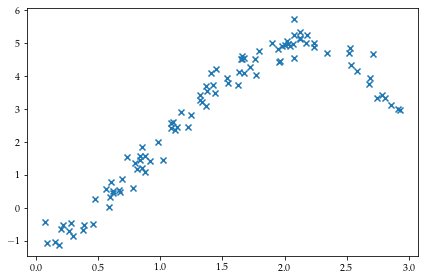

In [4]:
x, yobs = gen_mock_data()
y = yobs
print(x.shape, y.shape)
plt.scatter(x, y, marker = "x")
plt.show()

In [5]:
def prior(theta):
    """log-prior as a function of parameters `theta`.""" 
    a, b, c, d = theta
    lim = 1e6
    if abs(a) > lim or abs(b) > lim or abs(c) > lim:
        return -np.inf
    else:
        return 0.0

def loglike(theta, x, y, yerr):
    """log-likelihood as a function of parameters `theta`."""
    
    a, b, c, d = theta
    y_model = model(x, a, b, c, d)
    logl = - 0.5 * np.sum(((y - y_model)/yerr)**2)
    return logl

def logpost(theta, x=x, y=y, yerr=1):
    """(Negative) log-posterior as a function of parameters `theta`."""
    if not np.isfinite(prior(theta)):
        return -np.inf
    a, b, c, d = theta  # reassign parameters
    logp = prior(theta)  # prior
    logl = loglike(theta, x=x, y=y, yerr = yerr)  # likelihood
    return (logl + logp)  # posterior

In [6]:
initial = [a_guess, b_guess, c_guess, d_guess]
ndim = len(initial)
nwalkers = 100
niter = 1000


p0 = [np.array(initial) + 1 * np.random.randn(ndim) for i in range(nwalkers)]
p0 = np.array(p0, dtype = float)
print(p0.shape)

sampler = emcee.EnsembleSampler(nwalkers, ndim, logpost)

state = sampler.run_mcmc(p0, 100)
sampler.reset()

state = sampler.run_mcmc(state, niter, progress=True)

# get final chains
samples = sampler.get_chain()

(100, 4)


100%|██████████| 1000/1000 [00:04<00:00, 230.54it/s]


In [7]:
posteriors_pred = np.mean(sampler.get_chain(flat = True, discard = 100), axis = 0)

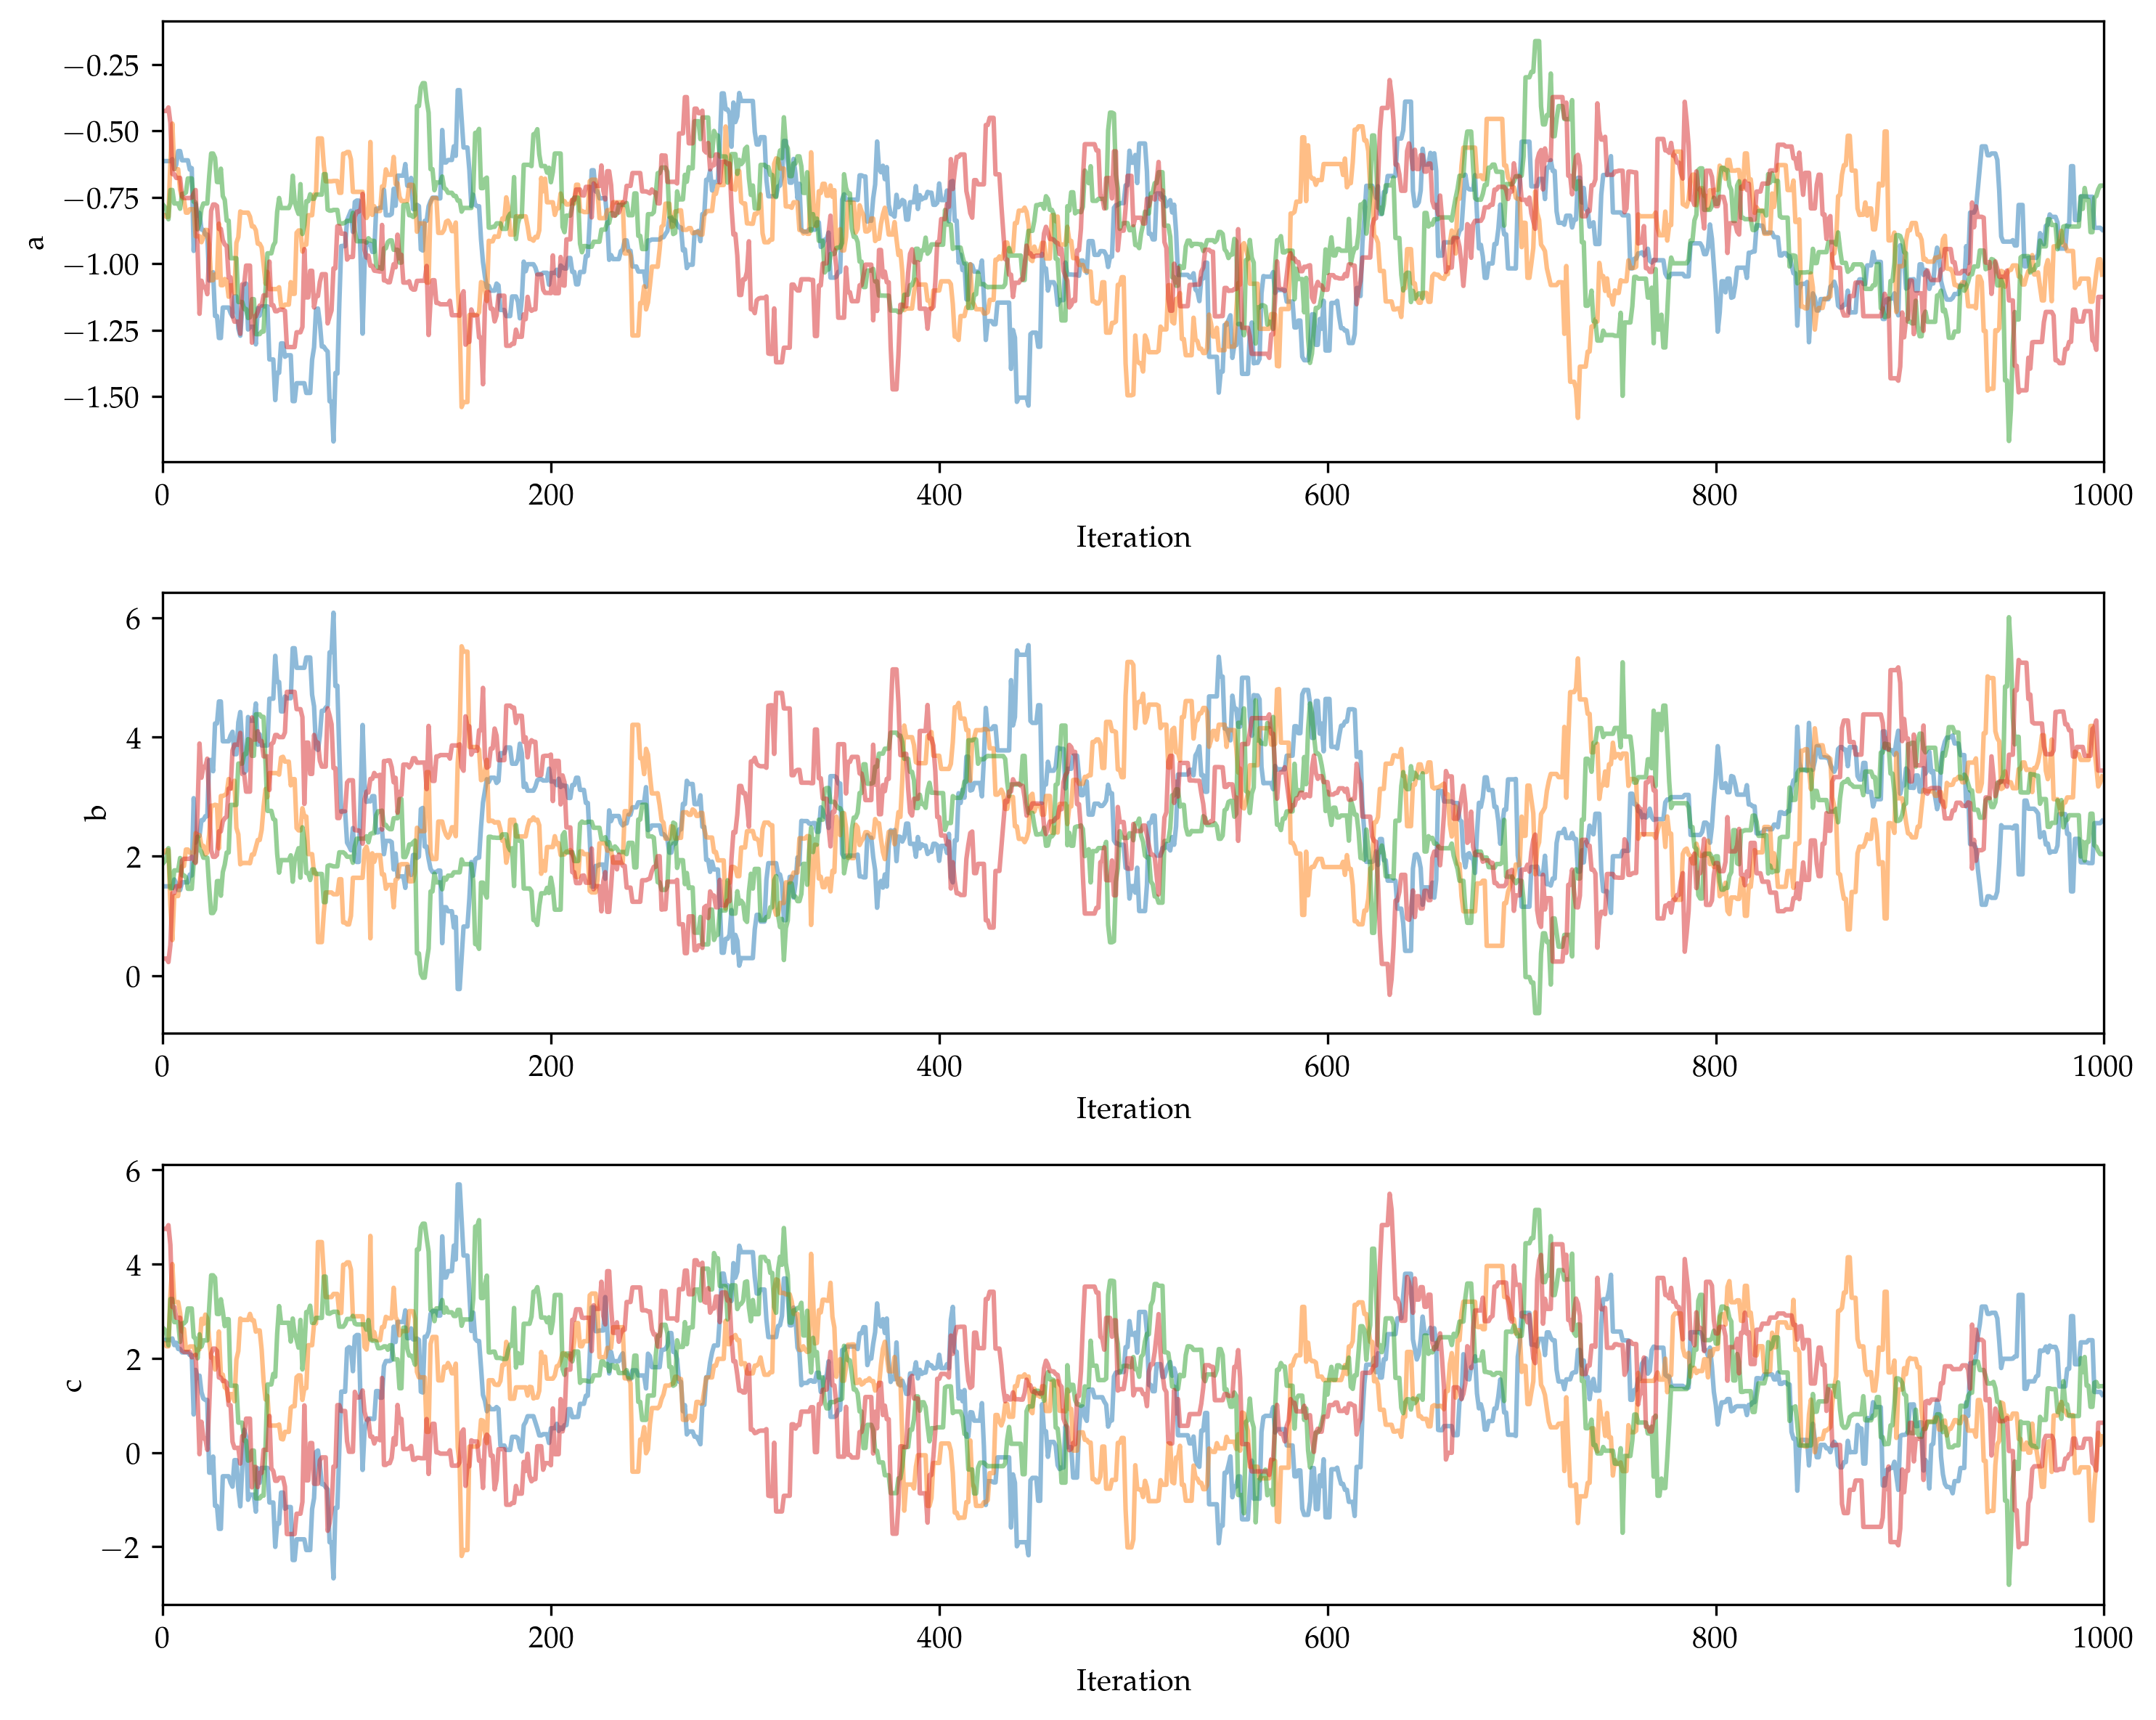

In [8]:
# plot a few chains
plt.figure(dpi = 300, figsize = (10,8))
# slope (m)
plt.subplot(3, 1, 1)
[plt.plot(samples[:, i, 0], alpha=0.5) for i in range(4)]
plt.xlim([0, niter])
plt.xlabel('Iteration')
plt.ylabel('a')
# intercept (b)
plt.subplot(3, 1, 2)
[plt.plot(samples[:, i, 1], alpha=0.5) for i in range(4)]
plt.xlabel('Iteration')
plt.ylabel('b')
plt.xlim([0, niter])
# scatter (s)
plt.subplot(3, 1, 3)
[plt.plot(samples[:, i, 2], alpha=0.5) for i in range(4)]
plt.xlim([0, niter])
plt.xlabel('Iteration')
plt.ylabel('c')
plt.tight_layout()

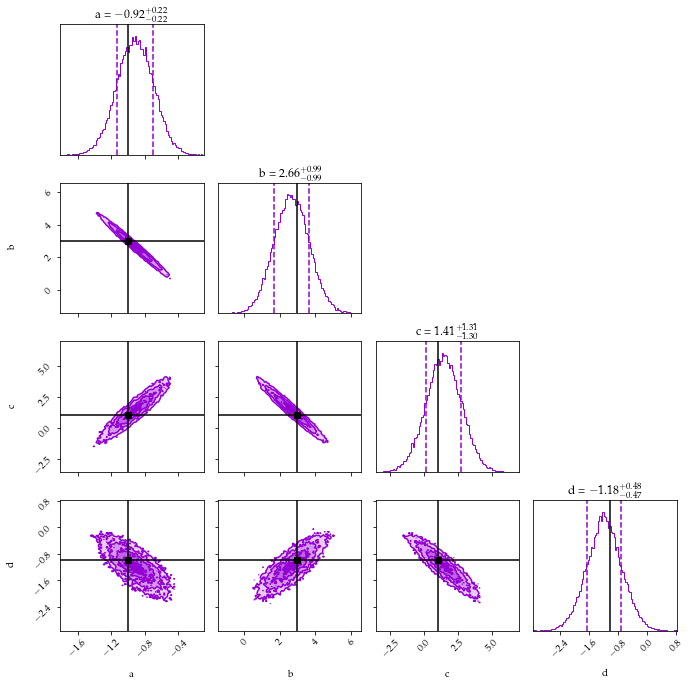

In [9]:
# plot posterior
corner.corner(samples.reshape(-1, ndim),  # collect samples into N x 3 array
              bins=100,  # bins for histogram
              show_titles=True, quantiles=[0.16, 0.84],  # show median and uncertainties
              labels=['a', 'b', 'c', "d"],
              truths=truth_arr,  # plot truth
              color='darkviolet', truth_color='black',  # add some colors
              **{'plot_datapoints': False, 'fill_contours': True});  # change some default options

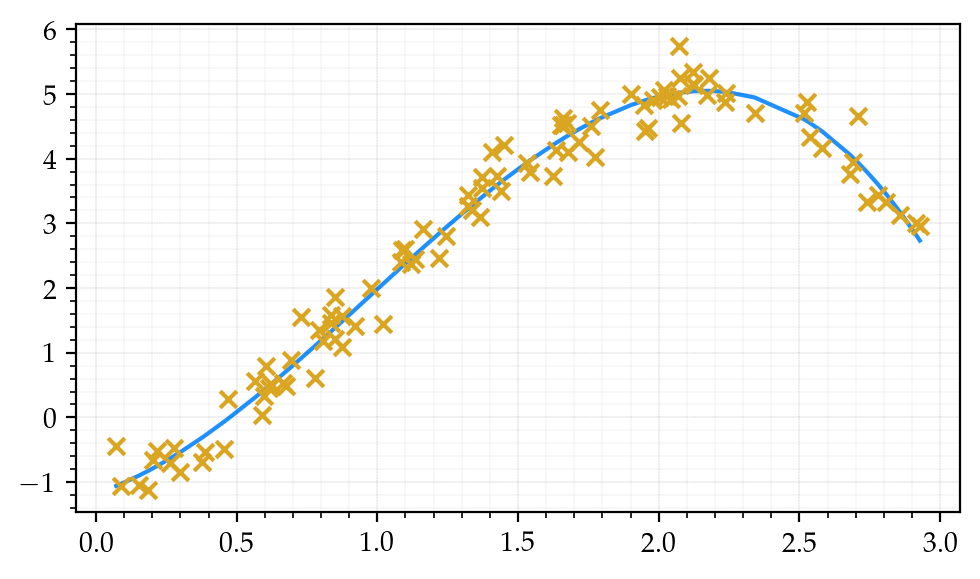

In [10]:
plt.figure(dpi = 200, figsize = (5,3))
utkarshGrid()
plt.scatter(x, y, color = "goldenrod", zorder = 2, marker = "x")
plt.plot(x, model(x, posteriors_pred[0], posteriors_pred[1], 
                  posteriors_pred[2], posteriors_pred[3]), zorder = 1, color = "dodgerblue")
plt.show()